# Parcial 1
Prgunta 3

El objetivo de este cuadernillo es el de construir una DCGAN para la generacion de imagenes de señales de tránsito, utilizando un discrimidor basado en VIT(Vision Transformer)

Se utilizara el dataset GTSRB (German Traffic Sign Recognition Benchmark) https://paperswithcode.com/dataset/gtsrb



In [1]:
import torch
import torch.nn as nn
import torchvision
import random
import matplotlib.pyplot as plt
from fastprogress import master_bar, progress_bar
import numpy as np
import pandas as pd
import math

device = "cuda" if torch.cuda.is_available() else "cpu"

Se carga el dataset GTSRB desde torchvision

In [2]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((36,36)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x.flatten()),
    torchvision.transforms.Lambda(lambda x: x * 2. - 1.)
])
trainset = torchvision.datasets.GTSRB('./data', split='train', download=True, transform=transform)
print('Imagenes:',len(trainset))

100%|██████████| 187490228/187490228 [00:06<00:00, 30776052.36it/s]


Extracting data/gtsrb/GTSRB-Training_fixed.zip to data/gtsrb
Imagenes: 26640


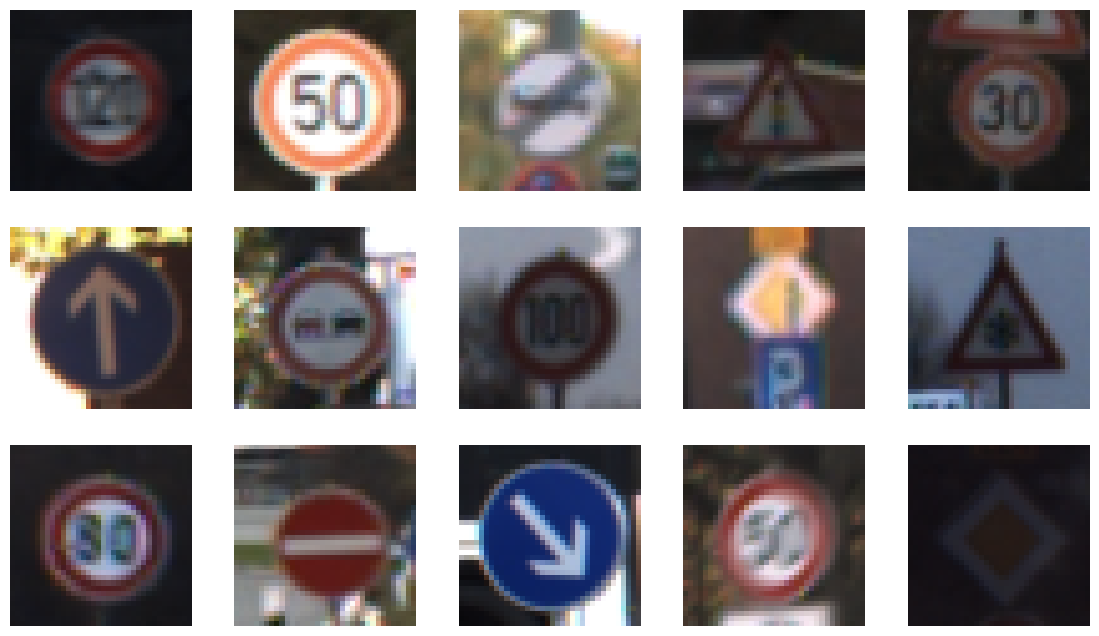

In [4]:
fig, axs = plt.subplots(3,5, figsize=(14,8))
for _ax in axs:
    for ax in _ax:
        ix = random.randint(0, len(trainset)-1)
        img, lab = trainset[ix]
        ax.imshow((img.reshape(3,36,36).permute(1,2,0)+1)/2)
        ax.axis('off')
        #ax.set_title(classes[lab])
plt.show()

Se crea el dataloader

In [5]:
dataloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

In [6]:
imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 3888]), torch.Size([32]))

## Generadores

In [5]:
class Generator1(nn.Module):
    def __init__(self):
        super(Generator1, self).__init__()
        self.channel = 3
        self.init_size = 9
        self.input_size = 100
        self.l1 = nn.Sequential(nn.Linear(self.input_size, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, self.channel, kernel_size=3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        out = self.l1(z)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        img = img.view(img.size(0), self.channel*36*36)
        return img

torch.Size([1, 3888])


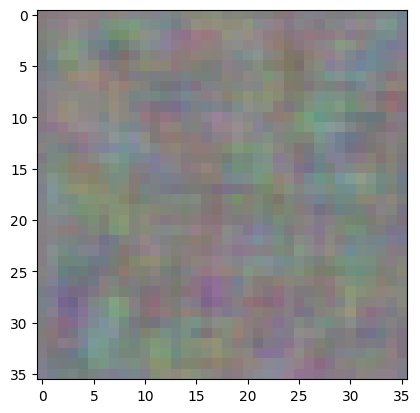

In [8]:
g = Generator1()
output = g(torch.randn(1, 100))
print(output.shape)
plt.imshow(output[0].view(3,36,36).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

In [9]:
class Generator2(nn.Module):
  def __init__(self):
    super().__init__()
    self.channel = 3
    self.init_size = 9
    self.input_size = 100
    self.inp = nn.Sequential(
        nn.Linear(self.input_size, 128 * self.init_size ** 2),
        nn.BatchNorm1d(128 * self.init_size ** 2),
    )
    self.main = nn.Sequential(
        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, self.channel, kernel_size=4, stride=2, padding=1, bias=False),
        nn.Tanh()
    )

  def forward(self, x):
    x = self.inp(x)
    x = x.view(-1, 128, self.init_size, self.init_size)
    x = self.main(x)
    x = x.view(x.size(0), self.channel*36*36)
    return x

torch.Size([2, 3888])


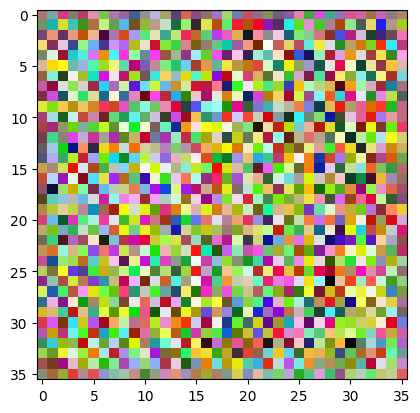

In [10]:
g_2 = Generator2()
output = g_2(torch.randn(2, 100))
print(output.shape)
plt.imshow(output[0].view(3,36,36).permute(1,2,0).detach().numpy()*0.5+0.5)
plt.show()

## Discrimidores

In [13]:
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, n_channels, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads
        self.n_embd_per_head = n_channels * n_embd // n_heads  # Calculate embedding size per head
        # Key, query, value projections
        self.key = torch.nn.Linear(n_channels * n_embd, n_channels * n_embd * n_heads)
        self.query = torch.nn.Linear(n_channels * n_embd, n_channels * n_embd * n_heads)
        self.value = torch.nn.Linear(n_channels * n_embd, n_channels * n_embd * n_heads)
        # Output projection
        self.proj = torch.nn.Linear(n_channels * n_embd * n_heads, n_channels * n_embd)

    def forward(self, x):
        B, L, F = x.size()
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side
        return self.proj(y)

In [14]:
class Discriminator1(nn.Module):
    def __init__(self, n_embd=9*9, seq_len=4*4, n_heads=9):
        super(Discriminator1, self).__init__()
        self.channel = 3
        self.attn = MultiHeadAttention(self.channel, n_embd, n_heads)
        self.adv_layer = nn.Sequential(
            nn.Linear(self.channel*n_embd*seq_len, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        #convierte en pachs
        img = img.view(img.size(0), 16, 3*9*9)
        #capa de atencion
        out = self.attn(img)
        #salida
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [15]:
d = Discriminator1()
output = d(torch.randn(2, 3*36*36))
output.shape

torch.Size([2, 1])

In [16]:
class Discriminator2(nn.Module):
    def __init__(self, n_embd=9*9, seq_len=4*4, n_heads=9):
        super(Discriminator2, self).__init__()
        self.channel = 3
        def discriminator_block(in_filters, out_filters, bn=True):
            block = [
                nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=2, padding=1),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Dropout2d(0.25)
            ]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block
        self.conv = nn.Sequential(
            *discriminator_block(self.channel, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )
        self.fc = nn.Linear(128*3*3, self.channel*36*36)
        self.attn = MultiHeadAttention(self.channel, n_embd, n_heads)
        self.adv_layer = nn.Sequential(
            nn.Linear(self.channel*n_embd*seq_len, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        # Capas convolucionl
        img = img.view(img.size(0), 3, 36, 36)
        img = self.conv(img)
        img = self.fc(img.view(img.size(0),-1))
        #convierte en pachs
        img = img.view(img.size(0), 16, 3*9*9)
        #capa de atencion
        out = self.attn(img)
        #salida
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        return validity

In [17]:
d = Discriminator2()
output = d(torch.randn(2, 3*36*36))
output.shape

torch.Size([2, 1])

Se define el metodo para el entrenamiento de la DCGAN

In [30]:
def fit(g, d, dataloader, epochs=5, lr=3e-4):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCELoss()
    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}
    for epoch in mb:
        for X, y in progress_bar(dataloader, parent=mb):
            X, y = X.to(device), y.to(device)
            # entrenamos el discriminador
            g.eval()
            d.train()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # input del discrminator
            d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])
            # gorund truth para el discriminator
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)
            # optimización
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())
            # entrenamos el generador
            g.train()
            d.eval()
            # generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            genenerated_images = g(noise)
            # salidas del discriminador
            d_output = d(genenerated_images)
            # gorund truth para el generator
            g_gt = torch.ones(X.size(0)).view(-1,1).to(device)
            # optimización
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())
            # logs
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))
    torch.save(g, 'drive/MyDrive/Colab Notebooks/generador4.pt')
    #torch.save(d, 'discriminador1.pt')
    return hist

# Modelo 1

In [ ]:
generator1 = Generator1()
discriminator1 = Discriminator1()

In [ ]:
hist1 = fit(generator1, discriminator1, dataloader, epochs=30)

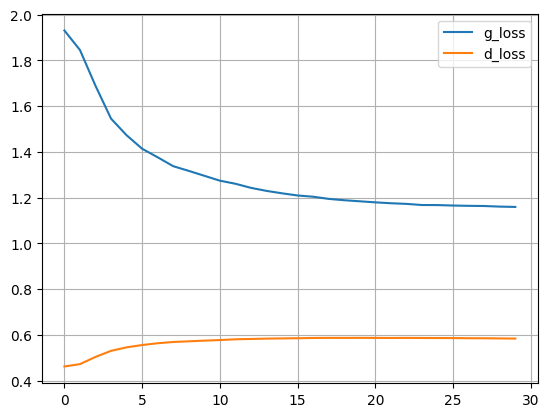

In [ ]:
df = pd.DataFrame(hist1)
df.plot(grid=True)
plt.show()

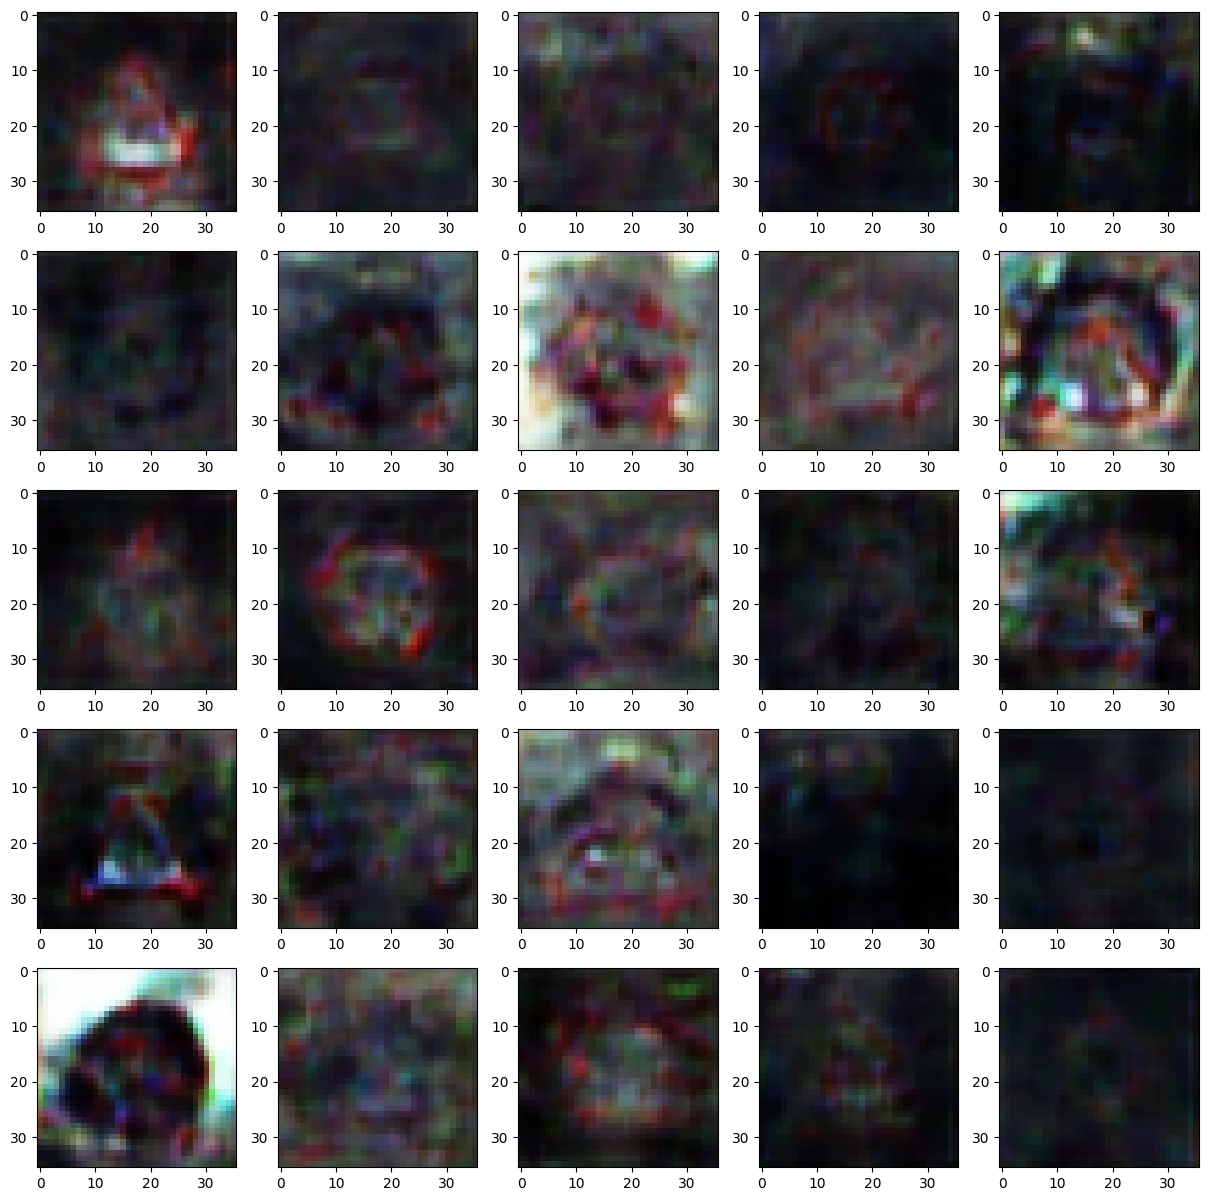

In [ ]:
generator1.eval()
with torch.no_grad():
  noise = torch.randn((25, generator1.input_size)).to(device)
  generated_images = generator1(noise)
  fig, axs = plt.subplots(5,5,figsize=(15,15))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,36,36).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

# Modelo 2

In [ ]:
generator2 = Generator1()
discriminator2 = Discriminator2()

In [ ]:
hist2 = fit(generator2, discriminator2, dataloader, epochs=30)

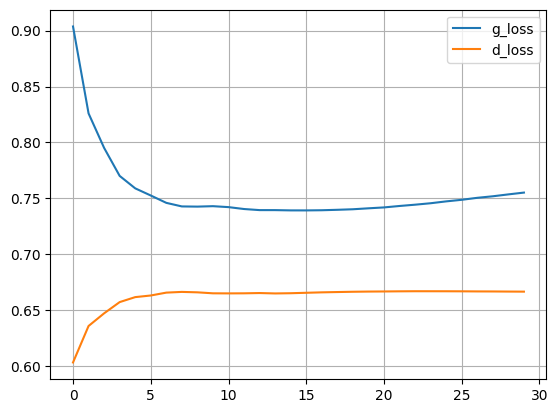

In [ ]:
df = pd.DataFrame(hist2)
df.plot(grid=True)
plt.show()

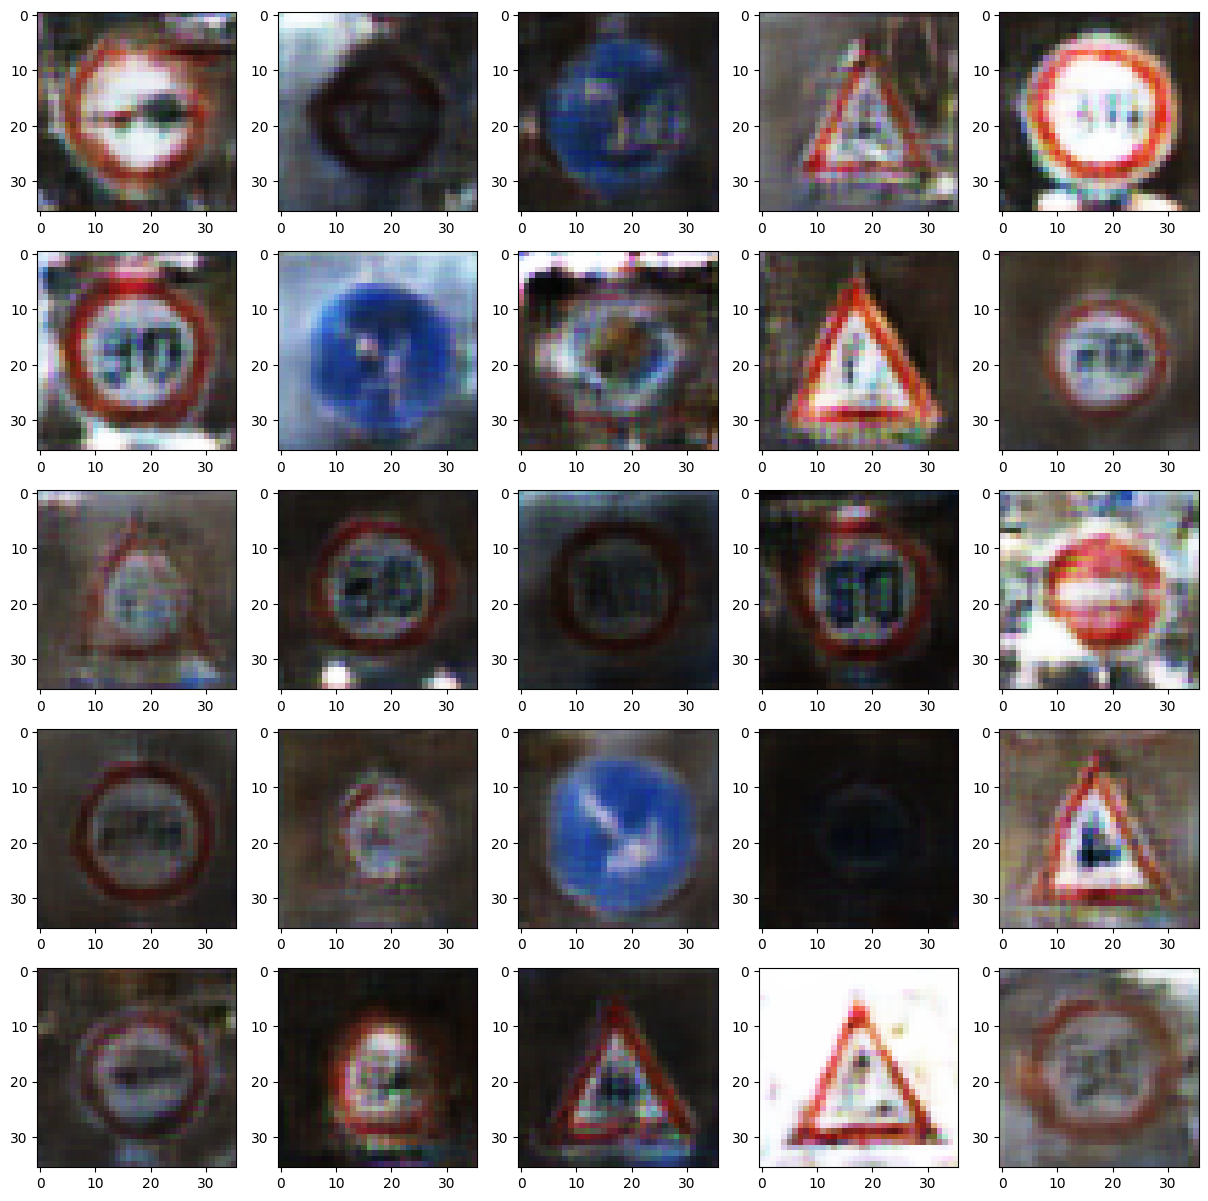

In [ ]:
generator2.eval()
with torch.no_grad():
  noise = torch.randn((25, generator2.input_size)).to(device)
  generated_images = generator2(noise)
  fig, axs = plt.subplots(5,5,figsize=(15,15))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,36,36).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()

Modelos ya entrenados

In [8]:
modelo = torch.load('drive/MyDrive/Colab Notebooks/generador2.pt')

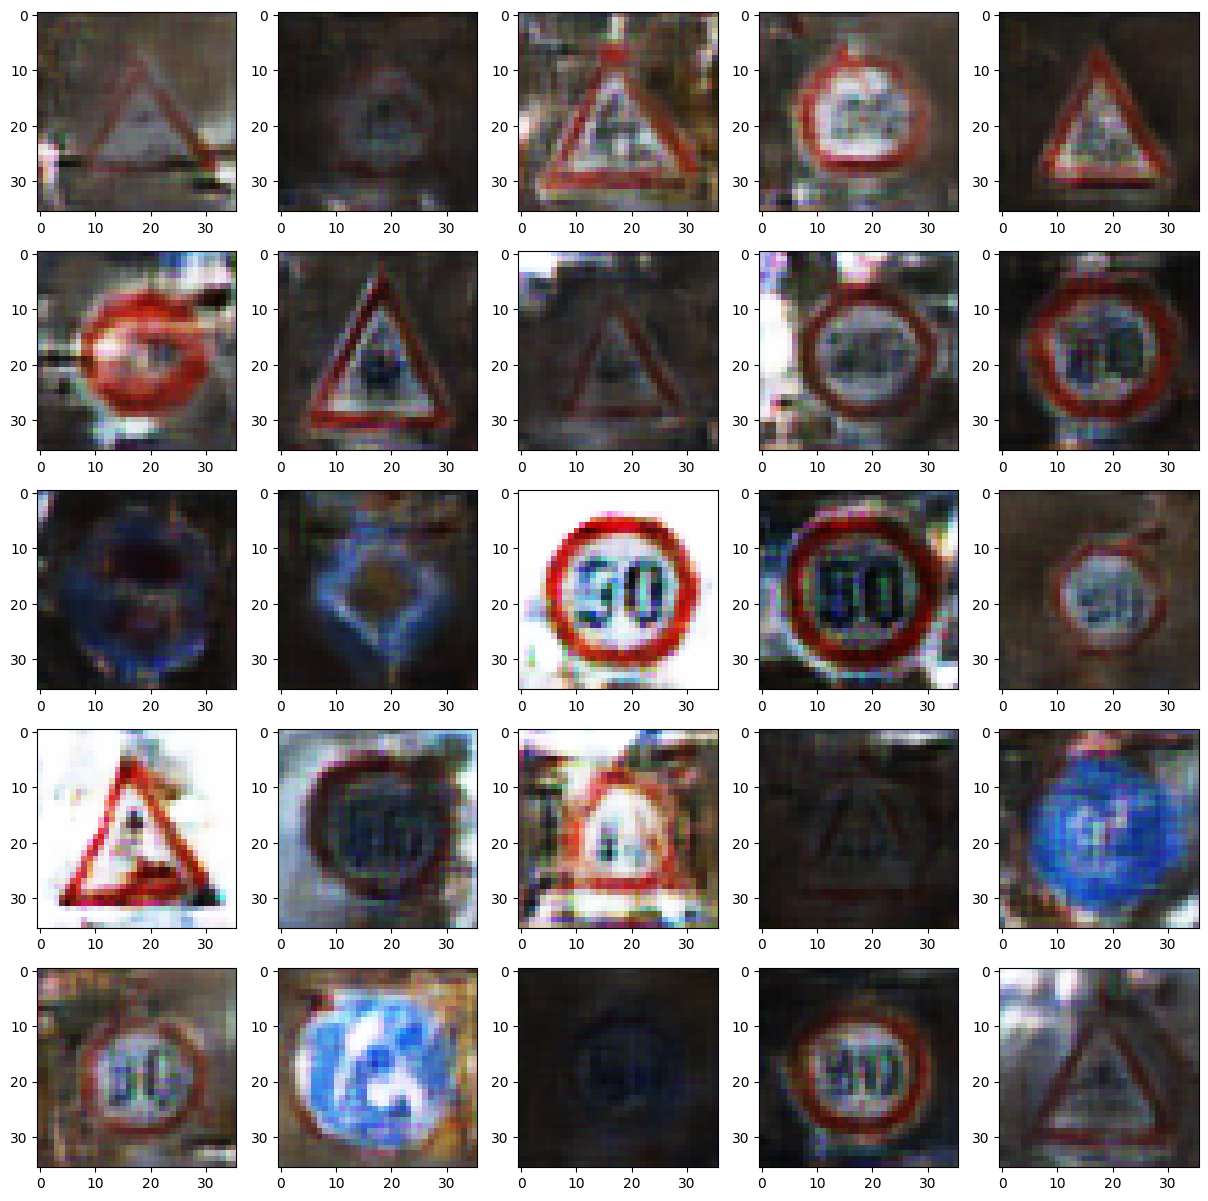

In [9]:
modelo.eval()
with torch.no_grad():
  noise = torch.randn((25, modelo.input_size)).to(device)
  generated_images = modelo(noise)
  fig, axs = plt.subplots(5,5,figsize=(15,15))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = (generated_images[i].view(3,36,36).permute(1,2,0).cpu())*0.5+0.5
      _ax.imshow(img)
      i+=1
  plt.show()